In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
df = pd.read_csv(r"/content/cancer.csv")

# Quick check
print(df.head())
print(df.columns)

   index Patient Id  Age  Gender  Air Pollution  Alcohol use  Dust Allergy  \
0      0         P1   33       1              2            4             5   
1      1        P10   17       1              3            1             5   
2      2       P100   35       1              4            5             6   
3      3      P1000   37       1              7            7             7   
4      4       P101   46       1              6            8             7   

   OccuPational Hazards  Genetic Risk  chronic Lung Disease  ...  Fatigue  \
0                     4             3                     2  ...        3   
1                     3             4                     2  ...        1   
2                     5             5                     4  ...        8   
3                     7             6                     7  ...        4   
4                     7             7                     6  ...        3   

   Weight Loss  Shortness of Breath  Wheezing  Swallowing Difficulty

In [ ]:
# ---- EDA ----
print(df.info())
print(df.isnull().sum())
print("Duplicates:", df.duplicated().sum())
print(df["Level"].value_counts(normalize=True))  # check balance

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     1000 non-null   int64 
 1   Patient Id                1000 non-null   object
 2   Age                       1000 non-null   int64 
 3   Gender                    1000 non-null   int64 
 4   Air Pollution             1000 non-null   int64 
 5   Alcohol use               1000 non-null   int64 
 6   Dust Allergy              1000 non-null   int64 
 7   OccuPational Hazards      1000 non-null   int64 
 8   Genetic Risk              1000 non-null   int64 
 9   chronic Lung Disease      1000 non-null   int64 
 10  Balanced Diet             1000 non-null   int64 
 11  Obesity                   1000 non-null   int64 
 12  Smoking                   1000 non-null   int64 
 13  Passive Smoker            1000 non-null   int64 
 14  Chest Pain               

In [ ]:
# Handle missing/duplicates if any
df = df.drop_duplicates()
df = df.dropna()

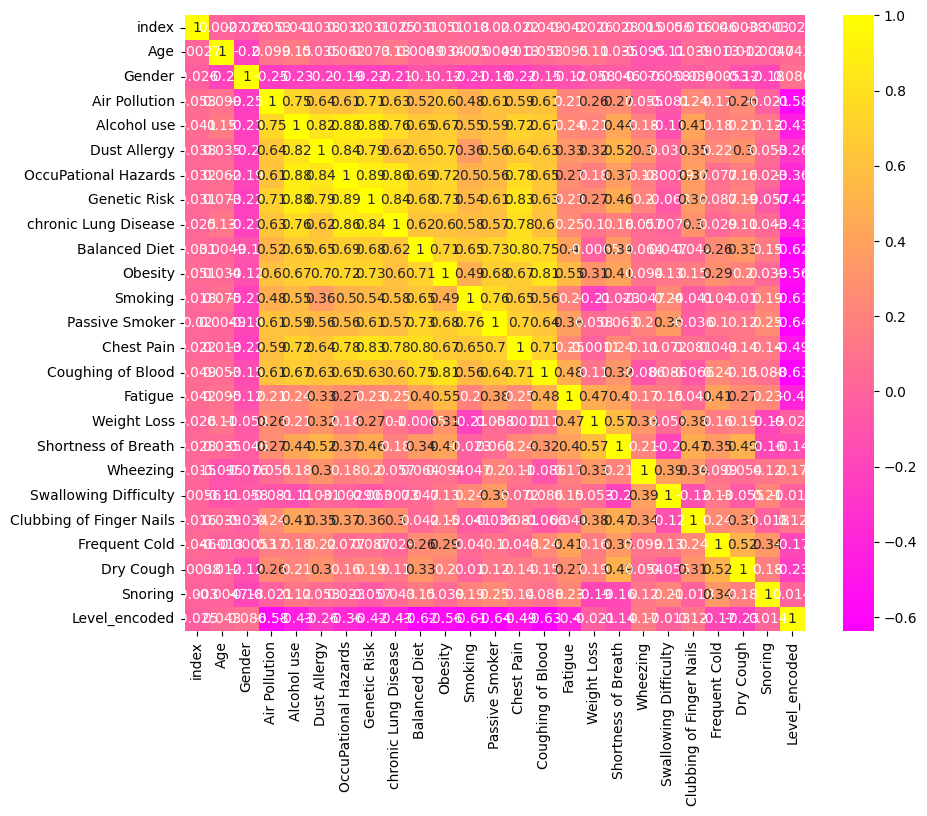


Correlation with Level (encoded):
Level_encoded               1.000000
Wheezing                    0.167773
Clubbing of Finger Nails    0.116746
Gender                      0.086222
Age                         0.042631
Snoring                     0.014280
Swallowing Difficulty      -0.012880
Weight Loss                -0.020537
index                      -0.024556
Shortness of Breath        -0.140178
Frequent Cold              -0.171678
Dry Cough                  -0.228720
Dust Allergy               -0.264926
OccuPational Hazards       -0.363748
Fatigue                    -0.403276
Genetic Risk               -0.423382
chronic Lung Disease       -0.432405
Alcohol use                -0.434071
Chest Pain                 -0.494704
Obesity                    -0.561961
Air Pollution              -0.577269
Smoking                    -0.611087
Balanced Diet              -0.618781
Coughing of Blood          -0.631118
Passive Smoker             -0.638409
Name: Level_encoded, dtype: float64


In [ ]:
# Encode Level
le = LabelEncoder()
df["Level_encoded"] = le.fit_transform(df["Level"])

# Keep only numeric columns + encoded target
numeric_df = df.select_dtypes(include=[np.number])

# Correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="spring")
plt.show()

# Correlation of all features with target
print("\nCorrelation with Level (encoded):")
print(numeric_df.corr()["Level_encoded"].sort_values(ascending=False))


In [ ]:
# Encode categorical target (Level)
le = LabelEncoder()
df["Level_encoded"] = le.fit_transform(df["Level"])

# Keep only numeric features (drop index, patient id, etc.)
numeric_df = df.drop(columns=["index", "Patient Id", "Level"])
numeric_df = numeric_df.select_dtypes(include=[np.number])

# Add encoded target back
numeric_df["Level_encoded"] = df["Level_encoded"]

# Pearson correlation with target
cor_matrix = numeric_df.corr()["Level_encoded"].abs().sort_values(ascending=False)

print("Correlation with Level:\n", cor_matrix)

Correlation with Level:
 Level_encoded               1.000000
Passive Smoker              0.638409
Coughing of Blood           0.631118
Balanced Diet               0.618781
Smoking                     0.611087
Air Pollution               0.577269
Obesity                     0.561961
Chest Pain                  0.494704
Alcohol use                 0.434071
chronic Lung Disease        0.432405
Genetic Risk                0.423382
Fatigue                     0.403276
OccuPational Hazards        0.363748
Dust Allergy                0.264926
Dry Cough                   0.228720
Frequent Cold               0.171678
Wheezing                    0.167773
Shortness of Breath         0.140178
Clubbing of Finger Nails    0.116746
Gender                      0.086222
Age                         0.042631
Weight Loss                 0.020537
Snoring                     0.014280
Swallowing Difficulty       0.012880
Name: Level_encoded, dtype: float64


In [ ]:
# ---- Encode categorical columns ----
df = df.drop(columns=["index", "Patient Id"])  # drop non-informative cols

# Encode Gender (if it's categorical)
if df["Gender"].dtype == "object":
    le_gender = LabelEncoder()
    df["Gender"] = le_gender.fit_transform(df["Gender"])

# Encode target (Level)
le_level = LabelEncoder()
y = le_level.fit_transform(df["Level"])

# Define features (all except Level)
X = df.drop("Level", axis=1)

# ---- Feature scaling ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Train/Test/Validation Split ----
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=0
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.3, random_state=0
)

# ---- KNN with different distance metrics ----
metrics = ["euclidean", "manhattan", "minkowski"]
results = []

for metric in metrics:
    knn = KNeighborsClassifier(n_neighbors=5, metric=metric)
    knn.fit(X_train, y_train)
    train_acc = knn.score(X_train, y_train)
    test_acc = knn.score(X_test, y_test)
    results.append((metric, train_acc, test_acc))

# ---- Print results ----
for metric, tr, te in results:
    print(f"Metric: {metric}, Train Acc: {tr:.4f}, Test Acc: {te:.4f}")


Metric: euclidean, Train Acc: 1.0000, Test Acc: 1.0000
Metric: manhattan, Train Acc: 1.0000, Test Acc: 1.0000
Metric: minkowski, Train Acc: 1.0000, Test Acc: 1.0000
